# Обучить GRU, LSTM для предсказания временного ряда 
на примере https://www.kaggle.com/c/favorita-grocery-sales-forecasting (для каждого типа продуктов)

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergeylazarevich","key":"859c9f7c80ea53aad29828f931d9c2e4"}'}

In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c favorita-grocery-sales-forecasting

 97% 443M/458M [00:06<00:00, 69.3MB/s]
100% 458M/458M [00:06<00:00, 71.8MB/s]


In [5]:
!unzip favorita-grocery-sales-forecasting.zip

Archive:  favorita-grocery-sales-forecasting.zip
  inflating: holidays_events.csv.7z  
  inflating: items.csv.7z            
  inflating: oil.csv.7z              
  inflating: sample_submission.csv.7z  
  inflating: stores.csv.7z           
  inflating: test.csv.7z             
  inflating: train.csv.7z            
  inflating: transactions.csv.7z     


In [6]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.1 MB/s 


In [8]:
!mkdir Data

In [9]:
from pyunpack import Archive
dir = 'Data'
Archive('holidays_events.csv.7z').extractall(dir)
Archive('train.csv.7z').extractall(dir)
Archive('items.csv.7z').extractall(dir)

In [10]:
!rm -rf kaggle.json
!rm -rf holidays_events.csv.7z 
!rm -rf train.csv.7z
!rm -rf items.csv.7z 
!rm -rf oil.csv.7z  
!rm -rf sample_submission.csv.7z
!rm -rf stores.csv.7z 
!rm -rf test.csv.7z 
!rm -rf transactions.csv.7z 
!rm -rf favorita-grocery-sales-forecasting.zip

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [12]:
# optimize memory loading by specifying the data types...
dtypes = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
df = pd.read_csv('./Data/train.csv', dtype=dtypes, parse_dates=['date'])

In [13]:
# Так как не хватает памяти урежем датасет до top 100 товаров
top = df['item_nbr'].value_counts().head(50).index
df = df.loc[df['item_nbr'].isin(top)].drop(['id'], axis=1)

In [15]:
# Так как не хватает памяти урежем датасет до периода 2017 года
df = df.loc[df['date'] >= '1/3/2017'].reset_index(drop=True)

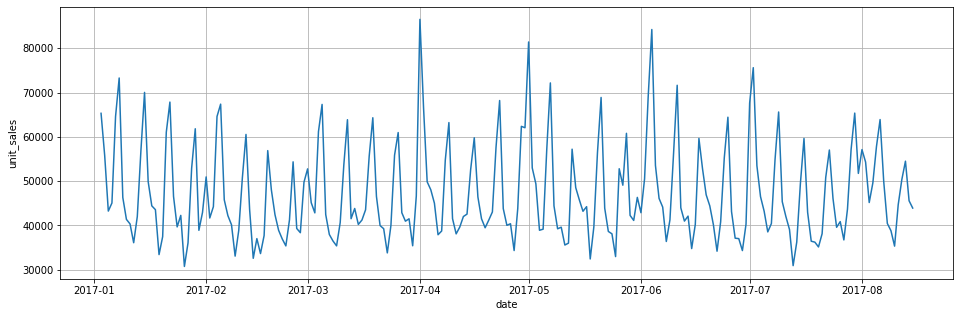

In [16]:
# сгруппируем по дате. 
df_ = df.groupby("date")['unit_sales'].sum().reset_index()
# черчение диаграммы
plt.figure(figsize = (16,5))
plt.plot(df_['date'].values, df_['unit_sales'].values)
plt.xlabel('date')
plt.ylabel('unit_sales')
plt.grid()
plt.show()

In [17]:
df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1}).fillna(0)

holidays_events_df = pd.read_csv('./Data/holidays_events.csv', parse_dates=['date'])
holidays_events_df = holidays_events_df.loc[holidays_events_df['type']=='Holiday', ['date', 'type']]
holidays_events_df['type'] = holidays_events_df['type'].map({'Holiday': 1})
df = df.merge(holidays_events_df, how='left', on='date')
df['type'] = df['type'].fillna(0)
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,type
0,2017-01-03,1,114790,6.0,0,0.0
1,2017-01-03,1,162066,4.0,0,0.0
2,2017-01-03,1,165594,6.0,0,0.0
3,2017-01-03,1,215331,1.0,0,0.0
4,2017-01-03,1,215352,18.0,0,0.0


In [18]:
df['dayofweek'] = df.apply(lambda x: x['date'].dayofweek, axis=1)
df['month'] = df.apply(lambda x: x['date'].month, axis=1)
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,type,dayofweek,month
0,2017-01-03,1,114790,6.0,0,0.0,1,1
1,2017-01-03,1,162066,4.0,0,0.0,1,1
2,2017-01-03,1,165594,6.0,0,0.0,1,1
3,2017-01-03,1,215331,1.0,0,0.0,1,1
4,2017-01-03,1,215352,18.0,0,0.0,1,1


In [19]:
items_df = pd.read_csv('./Data/items.csv')
items_df = items_df[['item_nbr', 'class', 'perishable']]
items_df['perishable'] = items_df['perishable'].map({0:1.0, 1:1.25})
df = df.merge(items_df, how='left', on='item_nbr')
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,type,dayofweek,month,class,perishable
0,2017-01-03,1,114790,6.0,0,0.0,1,1,1004,1.0
1,2017-01-03,1,162066,4.0,0,0.0,1,1,1048,1.0
2,2017-01-03,1,165594,6.0,0,0.0,1,1,1014,1.0
3,2017-01-03,1,215331,1.0,0,0.0,1,1,1040,1.0
4,2017-01-03,1,215352,18.0,0,0.0,1,1,1016,1.0


In [20]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

colums = ['store_nbr', 'item_nbr',	'onpromotion', 'type',	'dayofweek', 'month', 'class', 'perishable']
for colum in colums:
    df[colum] = sc.fit_transform(df[colum].to_numpy().reshape(-1, 1))

In [21]:
df.to_csv('/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks/data/train.csv',index=False)
#df = pd.read_csv('/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks/data/train.csv', parse_dates=['date'])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584290 entries, 0 to 584289
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         584290 non-null  datetime64[ns]
 1   store_nbr    584290 non-null  float64       
 2   item_nbr     584290 non-null  float64       
 3   unit_sales   584290 non-null  float64       
 4   onpromotion  584290 non-null  float64       
 5   type         584290 non-null  float64       
 6   dayofweek    584290 non-null  float64       
 7   month        584290 non-null  float64       
 8   class        584290 non-null  float64       
 9   perishable   584290 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 49.0 MB


In [23]:
test = df.loc[df['date'] > '7/1/2017'] 
train = df.loc[df['date'] <= '7/1/2017']

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117250 entries, 467040 to 584289
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         117250 non-null  datetime64[ns]
 1   store_nbr    117250 non-null  float64       
 2   item_nbr     117250 non-null  float64       
 3   unit_sales   117250 non-null  float64       
 4   onpromotion  117250 non-null  float64       
 5   type         117250 non-null  float64       
 6   dayofweek    117250 non-null  float64       
 7   month        117250 non-null  float64       
 8   class        117250 non-null  float64       
 9   perishable   117250 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 9.8 MB


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467040 entries, 0 to 467039
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         467040 non-null  datetime64[ns]
 1   store_nbr    467040 non-null  float64       
 2   item_nbr     467040 non-null  float64       
 3   unit_sales   467040 non-null  float64       
 4   onpromotion  467040 non-null  float64       
 5   type         467040 non-null  float64       
 6   dayofweek    467040 non-null  float64       
 7   month        467040 non-null  float64       
 8   class        467040 non-null  float64       
 9   perishable   467040 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 39.2 MB


In [26]:
#df = []
test = test.drop(['date'], axis=1)
train = train.drop(['date'], axis=1)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm

In [28]:
class Dataset(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset):
        self._base_dataset = init_dataset

    def __len__(self):
        return self._base_dataset.shape[0]

    def __getitem__(self, idx):
        y = self._base_dataset.iloc[idx]['unit_sales']
        x = self._base_dataset.iloc[idx].drop('unit_sales').to_numpy()
        return torch.tensor(x.astype(float), dtype=torch.float32),\
                torch.tensor([y], dtype=torch.float32)

In [29]:
train = Dataset(train)
test = Dataset(test)

In [30]:
train[21]

(tensor([0.0000, 0.4388, 1.0000, 0.0000, 0.1667, 0.0000, 0.0116, 0.0000]),
 tensor([15.]))

In [31]:
train_loader = torch.utils.data.DataLoader(train,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(test,
                          batch_size=128,
                          shuffle=False)

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


__Обучаем GRU__

In [33]:
class GRUFixedLen(nn.Module) :
    def __init__(self, input_dim=8, hidden_dim=50) :
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=input_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.linear(out)
        out = self.relu(out)
        return out
    

In [53]:
gru_init = GRUFixedLen()
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.01)
criterion = nn.MSELoss()
# Поместим нашу модель на GPU, если подключен.
gru_init.to(device)

GRUFixedLen(
  (gru): GRU(8, 50, num_layers=8, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
for epoch in tqdm(range(5)):  
    gru_init.train()
    print('')
    for counter, (x, y) in enumerate(train_loader, 0):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        outputs = gru_init(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        if counter % 1000 == 0:
            print(f"Epoch {epoch}.....Average Loss for Epoch: {loss.item()/len(y):.3f}")
        
    gru_init.eval()
    loss_accumed = 0
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        output = gru_init(x)
        loss = criterion(output, y)
        loss_accumed += loss
    print(f'\nEpoch {epoch} valid_loss {loss_accumed/len(test):.3f}')

print('Training is finished!')

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0.....Average Loss for Epoch: 5.294
Epoch 0.....Average Loss for Epoch: 5.370
Epoch 0.....Average Loss for Epoch: 2.523
Epoch 0.....Average Loss for Epoch: 3.158


 20%|██        | 1/5 [05:30<22:01, 330.36s/it]


Epoch 0 valid_loss 12.393

Epoch 1.....Average Loss for Epoch: 3.480
Epoch 1.....Average Loss for Epoch: 5.807
Epoch 1.....Average Loss for Epoch: 4.592
Epoch 1.....Average Loss for Epoch: 2.864


 40%|████      | 2/5 [11:04<16:38, 332.77s/it]


Epoch 1 valid_loss 12.374

Epoch 2.....Average Loss for Epoch: 3.452
Epoch 2.....Average Loss for Epoch: 3.303
Epoch 2.....Average Loss for Epoch: 3.092
Epoch 2.....Average Loss for Epoch: 1.882


 60%|██████    | 3/5 [16:38<11:06, 333.16s/it]


Epoch 2 valid_loss 12.390

Epoch 3.....Average Loss for Epoch: 5.930
Epoch 3.....Average Loss for Epoch: 3.821
Epoch 3.....Average Loss for Epoch: 9.745
Epoch 3.....Average Loss for Epoch: 2.212


 80%|████████  | 4/5 [22:11<05:33, 333.17s/it]


Epoch 3 valid_loss 12.374

Epoch 4.....Average Loss for Epoch: 2.039
Epoch 4.....Average Loss for Epoch: 17.660
Epoch 4.....Average Loss for Epoch: 2.897
Epoch 4.....Average Loss for Epoch: 3.717


100%|██████████| 5/5 [27:45<00:00, 333.08s/it]


Epoch 4 valid_loss 12.386
Training is finished!


__Обучаем LSTM__

In [55]:
class LSTM_variable_input(nn.Module) :
    def __init__(self, input_dim=8, hidden_dim=50) :
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=input_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        out = self.relu(out)
        return out

In [59]:
lstm_init = LSTM_variable_input()
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.01)
criterion = nn.MSELoss()
# Поместим нашу модель на GPU, если подключен.
lstm_init.to(device)

LSTM_variable_input(
  (lstm): LSTM(8, 50, num_layers=8, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [60]:
for epoch in tqdm(range(5)):  
    lstm_init.train()
    print('')
    for counter, (x, y) in enumerate(train_loader, 0):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        outputs = lstm_init(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        if counter % 1000 == 0:
            print(f"Epoch {epoch}.....Average Loss for Epoch: {loss.item()/len(y):.3f}")
        
    lstm_init.eval()
    loss_accumed = 0
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        output = lstm_init(x)
        loss = criterion(output, y)
        loss_accumed += loss
    print(f'\nEpoch {epoch} valid_loss {loss_accumed/len(test):.3f}')

print('Training is finished!')

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0.....Average Loss for Epoch: 10.934
Epoch 0.....Average Loss for Epoch: 4.116
Epoch 0.....Average Loss for Epoch: 6.465
Epoch 0.....Average Loss for Epoch: 6.872


 20%|██        | 1/5 [05:35<22:23, 335.96s/it]


Epoch 0 valid_loss 15.083

Epoch 1.....Average Loss for Epoch: 14.395
Epoch 1.....Average Loss for Epoch: 4.391
Epoch 1.....Average Loss for Epoch: 146.268
Epoch 1.....Average Loss for Epoch: 6.691


 40%|████      | 2/5 [11:10<16:45, 335.21s/it]


Epoch 1 valid_loss 15.083

Epoch 2.....Average Loss for Epoch: 22.176
Epoch 2.....Average Loss for Epoch: 7.014
Epoch 2.....Average Loss for Epoch: 7.345
Epoch 2.....Average Loss for Epoch: 26.486


 60%|██████    | 3/5 [16:43<11:08, 334.08s/it]


Epoch 2 valid_loss 15.083

Epoch 3.....Average Loss for Epoch: 8.717
Epoch 3.....Average Loss for Epoch: 7.311
Epoch 3.....Average Loss for Epoch: 15.117
Epoch 3.....Average Loss for Epoch: 4.898


 80%|████████  | 4/5 [22:15<05:33, 333.24s/it]


Epoch 3 valid_loss 15.083

Epoch 4.....Average Loss for Epoch: 9.406
Epoch 4.....Average Loss for Epoch: 6.312
Epoch 4.....Average Loss for Epoch: 8.027
Epoch 4.....Average Loss for Epoch: 142.932


100%|██████████| 5/5 [27:46<00:00, 333.40s/it]


Epoch 4 valid_loss 15.083
Training is finished!
